# Fine-tuning MedImageInsight with AzureML Pipelines

This notebook demonstrates how to fine-tune the MedImageInsight model using AzureML pipelines:

1. **Setup pre-requisites**: Install dependencies and authenticate to AzureML workspace.
2. **Data Handling**: Download, preprocess, and upload data to AzureML.
3. **Finetuning MedImageInsight**: Set model parameters and training configuration, then submit and monitor the fine-tuning job.
4. **Deploy and Validate the model**: Deploy the finetuned model. Review metrics and validation results, and analyze model outputs.

# 1. Setup pre-requisites
* Obtain the necessary dataset for training and evaluation
* Install [Azure ML Client library for Python](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-ml-readme?view=azure-python)
* Connect to AzureML Workspace and authenticate.

## Download Data
Go to [Gastrovision GitHub repository](https://github.com/debeshjha/gastrovision) and follow the links to download the data.  You can download directly to an AzureML compute with:

```sh
DATA_ROOT="/home/azureuser/data/healthcare-ai"  # Change to the location you downloaded the data

wget -O "$DATA_ROOT/Gastrovision.zip" '<url to zip>'
unzip "$DATA_ROOT/Gastrovision.zip" -d "$DATA_ROOT"
ls -l "$DATA_ROOT/Gastrovision/"
```



We are utilizing the Gastrovision dataset, which was not part of the original MI2 training. For more information, please visit the [Gastrovision GitHub repository](https://github.com/debeshjha/gastrovision). GastroVision is a dataset comprising 8000 endoscopy images collected from two hospitals in Norway and Sweden.



### Authenticate

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credentials = DefaultAzureCredential()
ml_client = MLClient.from_config(credentials)
ml_registry = MLClient(credential=credentials, registry_name="azureml")

Found the config file in: /config.json
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


# 2. Data Handling

## Preprocess the Data

After downloading the dataset, initial preprocessing steps are required.
We'll be generating a training dataset, a validation dataset and a testing dataset, using a 60/20/20 split.

The data needs to be stored in TSV files: one for labels and one for the actual images. We'll generate a total of 7 files:
   - Two training TSVs: image TSV and a text TSV.
   - Two validation TSVs: image TSV and a text TSV.
   - Two test TSVs: image TSV and a text TSV.
   - A text file with a full list of labels.


In [ ]:
import yaml

with open("text_constants.yaml", "r") as f:
    constants = yaml.safe_load(f.read())
    folder_to_label = constants["folder_to_label"]
    view_labels = constants["view_labels"]

labels_to_view = {vv: k for k, vlist in view_labels.items() for vv in vlist}

In [ ]:
import base64
from io import BytesIO
from PIL import Image
import pandas as pd
import glob
import os
from tqdm import tqdm


def gastro_folder_to_text(folder_name):
    label = folder_to_label[folder_name]
    view = labels_to_view[label]
    return f"endoscopy gastrointestinal {view} {label}"


data_root = "/home/azureuser/data/healthcare-ai"  # Change to the location you downloaded the data
gastrovision_root_directory = os.path.join(data_root, "Gastrovision")
text_to_label = {}
folders = os.listdir(gastrovision_root_directory)

for folder in folders:
    label = folder_to_label[folder]
    text = gastro_folder_to_text(folder)
    text_to_label[text] = label

data = []
files = list(
    glob.glob(os.path.join(gastrovision_root_directory, "**/*.jpg"), recursive=True)
)
for file_path in tqdm(files, ncols=120):
    folder = os.path.basename(os.path.dirname(file_path))
    filename = os.path.basename(file_path)
    text = gastro_folder_to_text(folder)
    with Image.open(file_path) as img:
        img = img.resize((512, 512)).convert("RGB")
        buffered = BytesIO()
        img.save(buffered, format="JPEG", quality=95)
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        data.append(
            [f"{folder}/{filename}-{os.path.basename(file_path)}", img_str, text]
        )

df = pd.DataFrame(data, columns=["filename", "image", "text"])

df.head()

100%|███████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:17<00:00, 31.11it/s]


,filename,image,text
0,Ileocecal valve/2b34f094-1ce4-4e73-9918-4a28c5...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,endoscopy gastrointestinal lower ileocecal valve
1,Ileocecal valve/a8fbaec2-d2a2-4db9-9536-ded2db...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,endoscopy gastrointestinal lower ileocecal valve
2,Ileocecal valve/97575f71-e3a0-4904-bad1-aac43b...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,endoscopy gastrointestinal lower ileocecal valve
3,Ileocecal valve/eeb55bd8-3c51-479a-bc56-aa08a2...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,endoscopy gastrointestinal lower ileocecal valve
4,Ileocecal valve/0992c2a4-1763-459d-bfc5-c9a738...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,endoscopy gastrointestinal lower ileocecal valve


In [ ]:
import csv
import json
from sklearn.model_selection import train_test_split

# Function to format text as JSON
def format_text_json(row):
    return json.dumps(
        {
            "class_id": text_index[row["text"]],
            "class_name": row["text"],
            "source": "gastrovision",
            "task": "classification",
        }
    )


# Filter the dataframe to only include the top 22 text captions
df_filtered = df[df["text"].isin(df["text"].value_counts().index[:22])].reset_index(
    drop=True
)

# Get unique texts from the filtered dataframe
unique_texts = df_filtered["text"].unique()

# Save the unique texts to a text file
with open("unique_texts.txt", "w") as f:
    for text in unique_texts:
        f.write(text + "\n")

# Create a dictionary to map text labels to indices
text_index = {label: index for index, label in enumerate(unique_texts)}

# Apply the formatting function to the text column
df_filtered["text"] = df_filtered.apply(format_text_json, axis=1)

# Split the dataframe into training, validation, and test sets
train_df, val_test_df = train_test_split(
    df_filtered, test_size=0.4, random_state=42, stratify=df_filtered["text"]
)
validation_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df["text"]
)

# Ensure that the train and validation sets have the same text distributions
if (
    len(train_df.value_counts("text"))
    != len(validation_df.value_counts("text"))
    != len(unique_texts)
):
    raise ValueError("Train and validation sets have different text distributions")

# Create separate dataframes for images and labels and save the dataframes to TSV files
def split_and_save_tsvs(aligned_df, prefix):
    image_df = aligned_df[["filename", "image"]]
    text_df = aligned_df[["filename", "text"]]
    text_df.to_csv(
        f"{prefix}_text.tsv",
        sep="\t",
        index=False,
        header=False,
        quoting=csv.QUOTE_NONE,
    )
    image_df.to_csv(f"{prefix}_images.tsv", sep="\t", index=False, header=False)


split_and_save_tsvs(train_df, "train")
split_and_save_tsvs(validation_df, "validation")
split_and_save_tsvs(test_df, "test")

## Upload Data to AzureML
We upload the data assets to the workspace. All assets are versioned, enabling you to track which assets have been used by each job.


In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

name = "gastrovision"
assets = {
    "image_tsv": "train_images.tsv",
    "text_tsv": "train_text.tsv",
    "eval_image_tsv": "validation_images.tsv",
    "eval_text_tsv": "validation_text.tsv",
    "label_file": "unique_texts.txt",
}

data_assets = {
    key: Data(
        path=value,
        type=AssetTypes.URI_FILE,
        description=f"{name} {key}",
        name=f"{name}-{key}",
    )
    for key, value in assets.items()
}

for key, data in data_assets.items():
    data_assets[key] = ml_client.data.create_or_update(data)
    print(
        f"Data asset {key} created or updated.",
        data_assets[key].name,
        data_assets[key].version,
    )

Data asset image_tsv created or updated. gastrovision-image_tsv 37
Data asset text_tsv created or updated. gastrovision-text_tsv 37
Data asset eval_image_tsv created or updated. gastrovision-eval_image_tsv 35
Data asset eval_text_tsv created or updated. gastrovision-eval_text_tsv 33
Data asset label_file created or updated. gastrovision-label_file 35


Uploading validation_images.tsv (< 1 MB): 109MB [00:01, 108MB/s]                             


Uploading validation_text.tsv (< 1 MB): 100%|██████████| 393k/393k [00:00<00:00, 11.3MB/s]




# 3. Finetuning MedImageInsight
##  Training the Model

We're getting ready to kick off the training job.

First, we'll create a compute cluster. Replace `compute_name` as needed. For more details, refer to the [AzureML documentation](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-compute-cluster?view=azureml-api-2&tabs=python).

Once the cluster is created, we can start the fine-tuning job. We'll retrieve the latest version of MedImageInsight model from the catalog and reference our fine-tuning pipeline. Azure ML pipelines is an invaluable feature of Azure Machine Learning product that allows organizing multiple tasks involved in a machine learning job into a structured workflow that can also be visualized inside the studio. See [AzureML documentation](https://learn.microsoft.com/en-us/azure/machine-learning/concept-ml-pipelines) for more information on pipelines. One advantage of using pipelines is access to all components. For example, if you only want to train the base model and not create a classification model, you can do that. Fine tuning of MedImageInsight is enabled by several pipeline components that we have developed and published in the Azure ML pipeline registry - you can find them if you navigate to Pipeline Designer inside the Azure ML Studio and look for them in the component selector. 

These components are:
1. **MedImageInsight Model Finetuning Core Component** [`medimgageinsight_embedding_finetune`](https://ml.azure.com/registries/azureml/components/medimageinsight_embedding_finetune):  
   This is the engine behind the fine-tuning process, responsible for training the MedImageInsight model.
   It also supports distributed training across a multi-GPU cluster. 
   
   Inputs:
   - Two training TSVs: image TSV and a text TSV.
   - Two validation TSVs: image TSV and a text TSV.
   - A text file with a full list of labels.
   - A training configuration file.

2. **MedImageInsight Embedding Generation Component** [`medimageinsight_embedding_generation`](https://ml.azure.com/registries/azureml/components/medimageinsight_embedding_generation):  
   This component generates embeddings from images using the MedImageInsight model. It allows you to adjust image quality and dimensions, ultimately outputting a pickled NumPy array that contains embeddings for all processed images.

   Inputs:
   - The image TSV of images to be converted into embeddings.
   - The MI2 model to use
   - (Optional) An integer value for JPEG compression ratio for image standardization (`default: 75`)
   - (Optional) And integer value to use for image size standardization (`default: 512`)

3. **MedImageInsight Adapter Finetune Component** [`medimageinsight_adapter_finetune`](https://ml.azure.com/registries/azureml/components/medimageinsight_adapter_finetune):  
   Designed for classification tasks, this component uses NumPy arrays of training and validation data along with their corresponding text labels (from TSV files) to train a specialized 3-layer model. It is optimized for specific domains while still retaining the core strengths of MI2.

   Inputs:
   - Two training TSVs: image TSV and a label TSV.
   - Two validation TSVs: image TSV and a label TSV.
   - A text file with a full list of labels.
   - A training configuration file.
   - Model Params: Hidden dimensions (default: 512, min: 1); Input channels (default: 1024, min: 1).
   - Training Params: Dataloader batch sizes, training (default: 8) and validation (default: 1, min: 1); Dataloader workers, training and validation (default: 2, min: 0); Learning rate (default: 0.0003); Max epochs (default: 10, min: 1).
   - Metrics: Track metric (default: acc; supports "acc" or "auc").

4. **MedImageInsight Image Classifier Assembler Component** [`medimageinsight_classification_model`](https://ml.azure.com/registries/azureml/components/medimageinsight_classification_model):  
   This component merges your fine-tuned embedding model with a label file to create a deployable image classifier. It accepts the fine-tuned MI2 embedding model, text labels, and an optional adapter model, packaging them into an MLFlow model that can operate in zero-shot mode or with a custom adapter model.

    Inputs:
    - A required URI file specifying the label file.
    
       **and**:
    
    - An optional MLFlow model asset for integration.
    
       **or**: 
    
    - An optional custom model for adapter training.
    - An optional integer for hidden dimensions (default: 512, min: 1).
    - An optional integer for input channels (default: 1024, min: 1).

5. **MedImageInsight Pipeline Component** [`medimageinsight_ft_pipeline`](https://ml.azure.com/registries/azureml/components/medimageinsight_ft_pipeline):  
   This end-to-end pipeline simplifies the workflow by integrating all the above components. It orchestrates the training, evaluation, and final output of the embedding and classification models. The pipeline essentially combines the functionalities of `medimageinsight_embedding_finetune` and `medimageinsight_classification_model` into a streamlined process.
    
    Inputs:
    - Two training TSVs: image TSV and a text TSV.
    - Two validation TSVs: image TSV and a text TSV.
    - A text file with a full list of labels.
    - A training configuration file.

You can also chain different components together and provide your own data preprocessing or adapter implementations. For more details, refer to the [AzureML documentation](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-pipeline-component?view=azureml-api-2&tabs=python).

Here we are using **MedImageInsight Pipeline Component** (`medimageinsight_ft_pipeline`) so you should see a job like this:
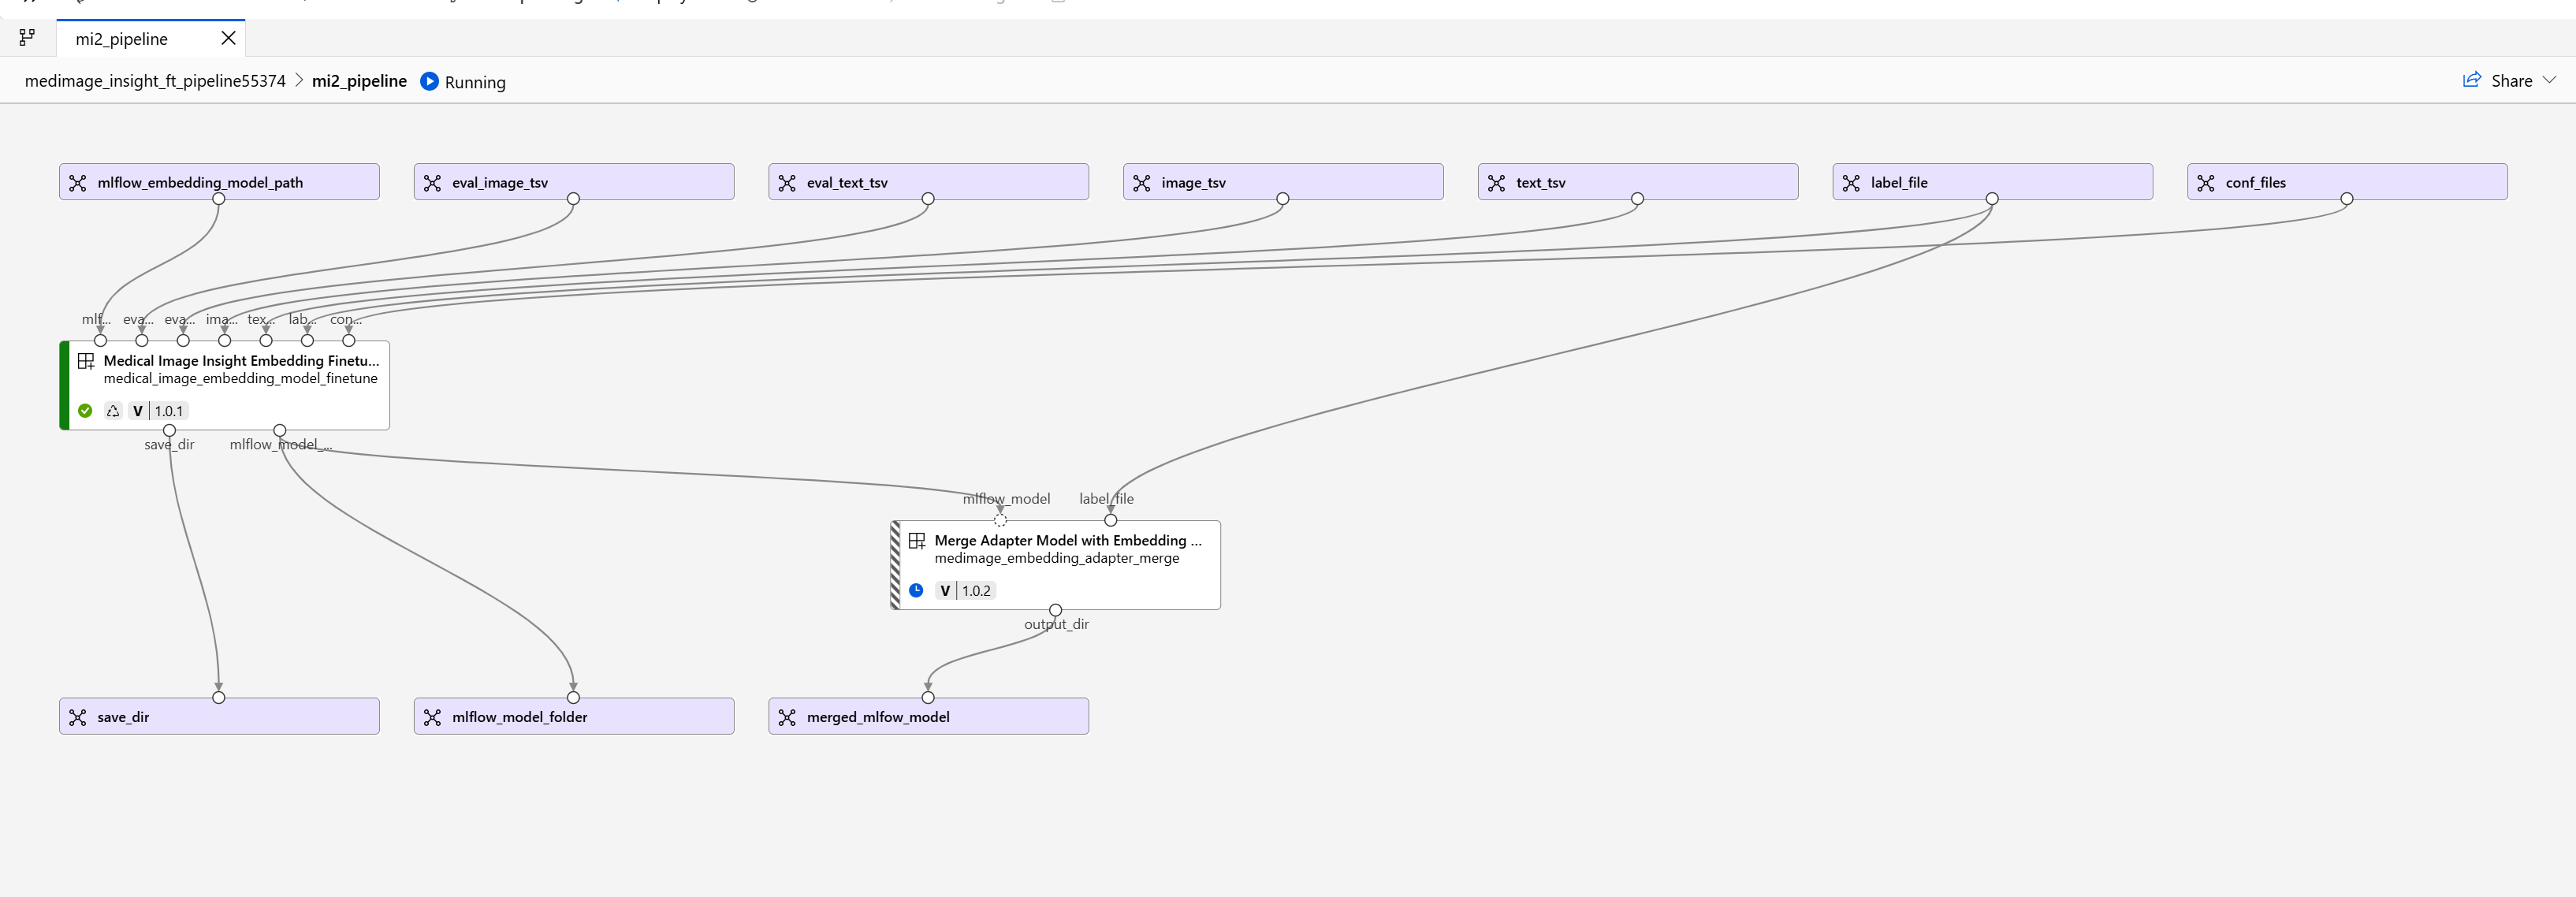


## Select Your Compute Resources

In this section, you will set up the compute resources needed for fine-tuning MedImageInsight models:

- **Compute type**: For MedImageInsight fine-tuning, you'll need GPU-based compute for optimal performance
- **Recommended SKU**: Use `Standard_NC24ads_A100_v4` or `Standard_NC96ads_A100_v4` with NVIDIA A100 GPUs or better for best results
- **Cluster configuration**: Set minimum instances to 0 and maximum to your needed scale (2-4 nodes recommended)
- **Cost consideration**: GPU compute can be expensive, so ensure auto-shutdown is enabled when not in use
- **Memory requirements**: Select instances with at least 32GB RAM per GPU for handling medical imaging datasets


If you are working with smaller datasets, you could use smaller GPU instances like `Standard_NC6s_v3`, but training will take longer.
**You will also need to change the batch_size in the config file, see below.**

In [ ]:
from azure.ai.ml.entities import AmlCompute

compute_name = "gpucluster"
if not any(filter(lambda m: m.name == compute_name, ml_client.compute.list())):
    compute_cluster = AmlCompute(
        name=compute_name,
        description="GPU cluster compute for fine-tuning",
        min_instances=0,
        max_instances=12,
        size="Standard_NC24ads_A100_v4",
    )
    compute = ml_client.compute.begin_create_or_update(compute_cluster).result()
else:
    compute = ml_client.compute.get(compute_name)

##  The Training Config File
All the settings for training are defined in the ./train-gastrovision.yaml configuration file. This YAML file contains parameters that control various aspects of the training process, including:

* Training hyperparameters (learning rate, batch size, epochs)
* Preprocessing settings
* Optimization settings

You can modify any of these settings to customize your training job according to your specific requirements. Before starting the training process, take a moment to review and adjust these settings as needed. 

If you need to decrease the batch size for a smaller GPU these are the settings you need to modify:

```yaml
...
TEST:
  BATCH_SIZE_PER_GPU: 2 # Was 8
...
TRAIN:
  BATCH_SIZE_TOTAL: 48 # This is the total batch size, you do not need to change it.
  BATCH_SIZE_PER_GPU: 2 # WAS 4, make this value as large as possible without triggering CUDA OOM
...
```

_Note:_ this will make training take longer!

In [ ]:
conf_file = "train-gastrovision.yaml"
data = Data(
    path=conf_file,
    type=AssetTypes.URI_FILE,
    description=f"{name} conf_files",
    name=f"{name}-conf_files",
)
data_assets["conf_files"] = ml_client.data.create_or_update(data)

In [ ]:
from azure.ai.ml.dsl import pipeline
import random

# Get the pipeline component
finetune_pipline_component = ml_registry.components.get(
    name="medimageinsight_ft_pipeline", label="latest"
)
print(
    "Component loaded",
    finetune_pipline_component.name,
    finetune_pipline_component.version,
)

# Get the latest MI2 model
model = ml_registry.models.get(name="MedImageInsight", label="latest")


@pipeline(name="medimageinsight_ft_pipeline_job" + str(random.randint(0, 100000)))
def create_pipeline():
    mi2_pipeline = finetune_pipline_component(
        mlflow_embedding_model_path=model.id,
        compute_finetune=compute.name,
        instance_count=8,
        **data_assets,
    )
    return {
        "classification_model": mi2_pipeline.outputs.classification_mlflow_model,
        "embedding_model": mi2_pipeline.outputs.embedding_mlflow_model,
    }  # If you are only training the base model, only specify "embedding_model": mi2_pipeline.outputs.embedding_mlflow_model


pipeline_object = create_pipeline()
pipeline_object.compute = compute.name
pipeline_object.settings.continue_on_step_failure = False
pipeline_job = ml_client.jobs.create_or_update(pipeline_object, experiment_name=name)
pipeline_job_run_id = pipeline_job.name
pipeline_job

Component loaded medimage_insight_ft_pipeline 0.0.2


Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
pathOnCompute is not a known attribute

Experiment,Name,Type,Status,Details Page
gastrovision,coral_zoo_57r8bs0xmc,pipeline,NotStarted,Link to Azure Machine Learning studio


## Monitor the Training Job

Wait for the job to complete. Click on the provided link to observe real-time metrics for the base model embedding fine-tuning.

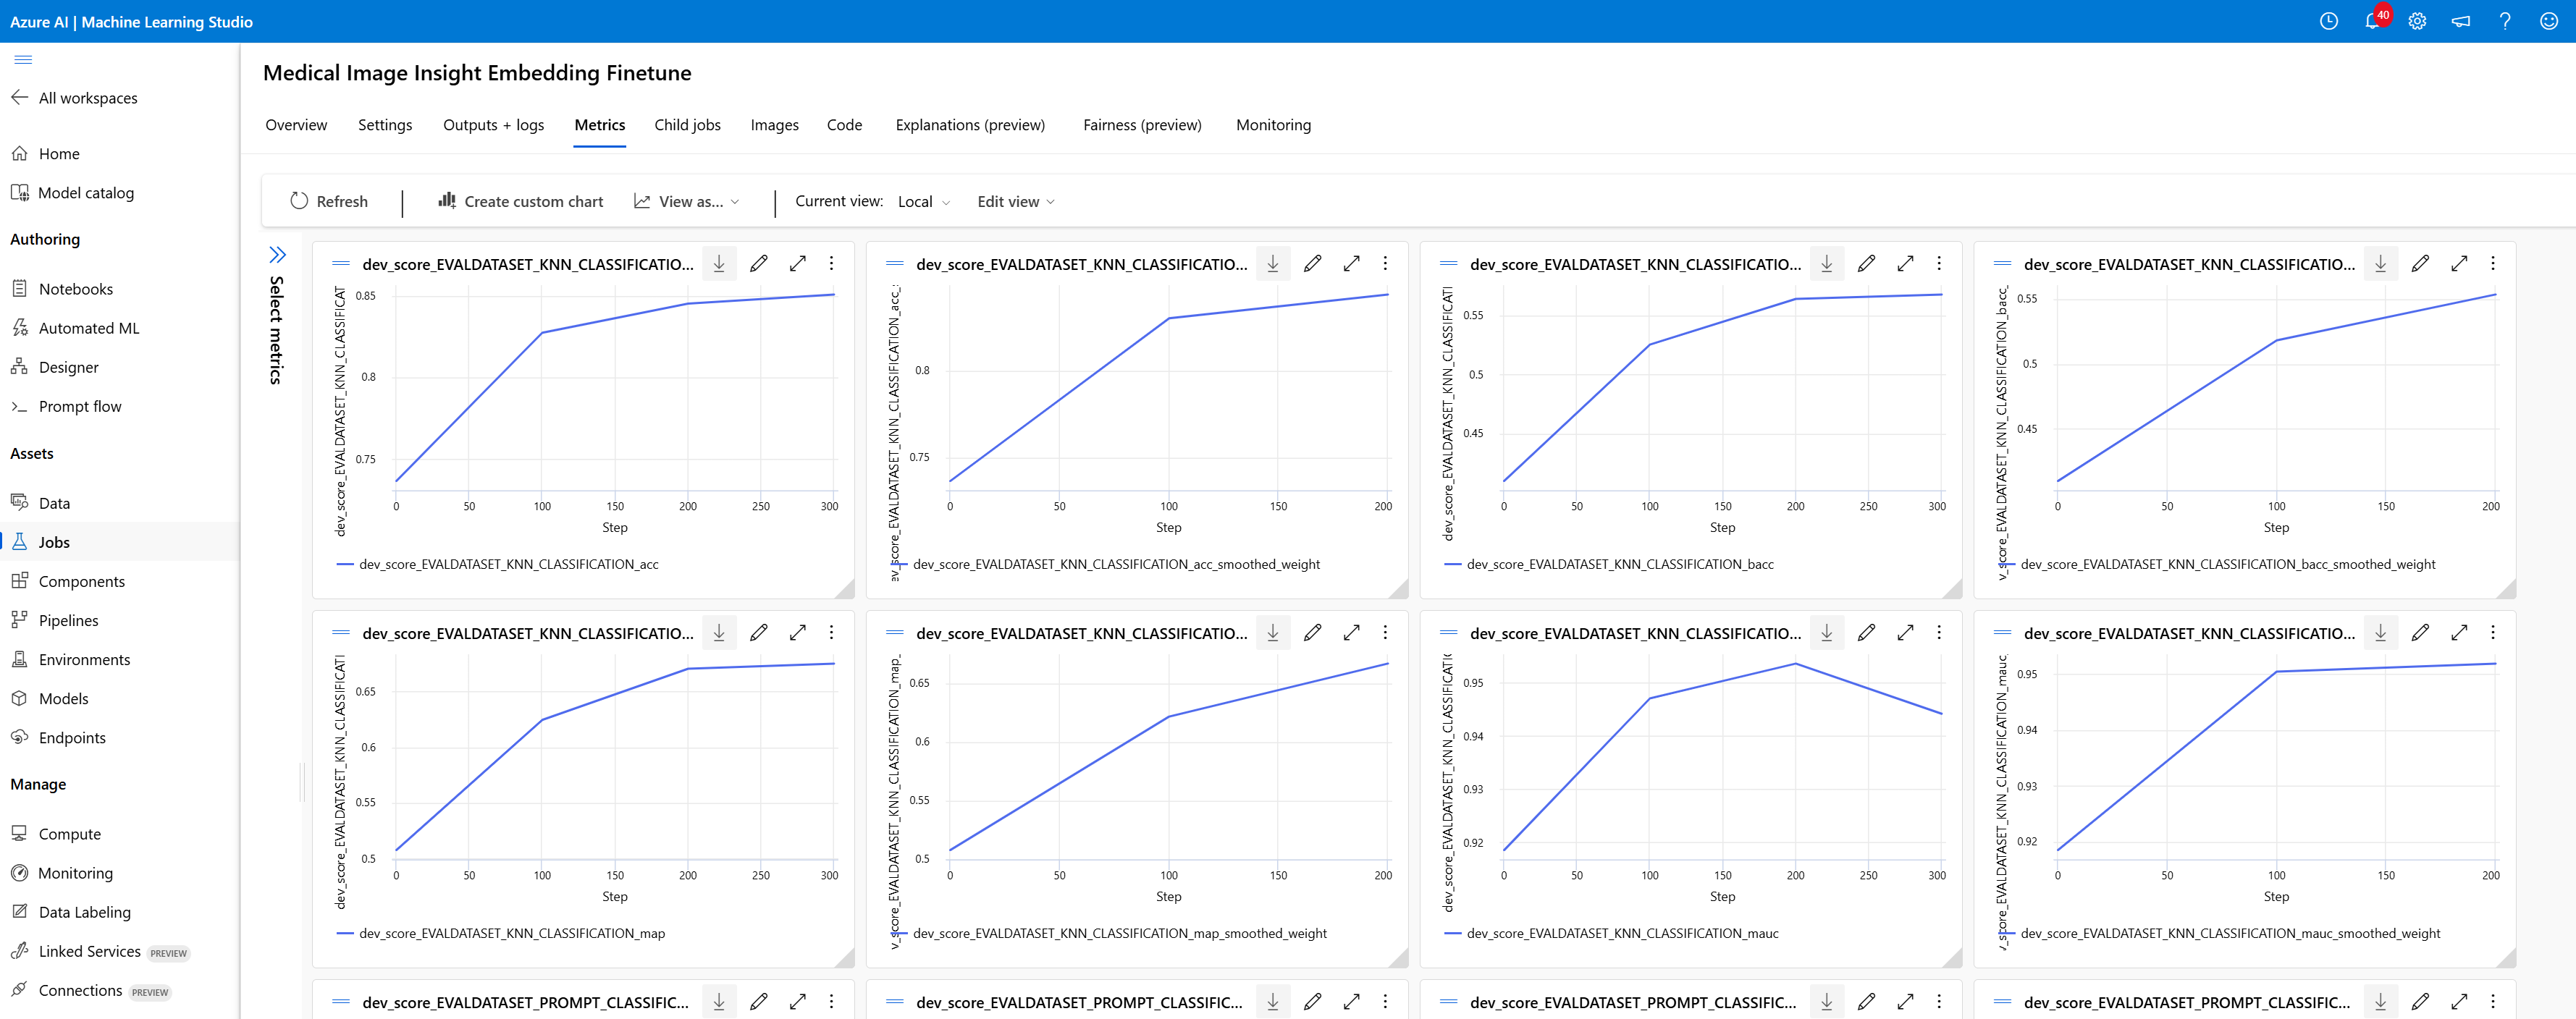

In [ ]:
ml_client.jobs.stream(pipeline_job.name)

# 4. Deploy and Validate the Model

In this section, we deploy a classifier model that leverages the embedding generated by your fine-tuned MI2 model. Note that training the classifier can take several hours. If your kernel became idle or disconnected, certain variables have been re-initialized automatically. In such cases, make sure to reset the value of `pipeline_job_run_id` to the appropriate identifier to continue tracking or associating the current run.

In [ ]:
# Run this cell if you reconnected to the notebook.

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credentials = DefaultAzureCredential()
ml_client = MLClient.from_config(credentials)

data_root = "/home/azureuser/data/healthcare-ai"  # Change to the location you downloaded the data
gastrovision_root_directory = os.path.join(data_root, "Gastrovision")
name = "gastrovision"
if "pipeline_job_run_id" not in locals():
    ##  Retrieved by checking the json of the parent job in AzureML studio (under "See all properties") or in output of the cell where you started the job under "Name".
    pipeline_job_run_id = ""

if not len(pipeline_job_run_id):
    raise ValueError(
        "Your kernel may have died! You need to set the pipeline_job_run_id manually from the output above (job name), or from the experiment in AzureML portal."
    )

pipeline_job = ml_client.jobs.get(name=pipeline_job_run_id)

with open("unique_texts.txt", "r") as f:
    unique_texts = [s.strip() for s in f.readlines()]

Found the config file in: /config.json
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


## Register the Model

Register the model from the data asset pipeline. Deploy the model as an online endpoint, and run a final evaluation to assess its performance.


In [ ]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
)

# Create a Model to register
run_model = Model(
    path=f"azureml://jobs/{pipeline_job.name}/outputs/classification_model",
    name=f"classifier-{name}-{pipeline_job.name}",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL,
)

# Register the Model
run_model = ml_client.models.create_or_update(run_model)

# Create endpoint and deployment with the classification model
endpoint = ManagedOnlineEndpoint(name=name)
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()
deployment = ManagedOnlineDeployment(
    name=name,
    endpoint_name=endpoint.name,
    model=run_model.id,
    instance_type="Standard_NC6s_v3",
    instance_count=1,
)
deployment = ml_client.online_deployments.begin_create_or_update(deployment).result()

Check: endpoint gastrovision exists


.....................................................................................................................................................................

## Validate the model 
We're now ready to analyze the results. The model has been deployed as an online endpoint. We'll run through our evaluation dataset to compare expected and actual classifications.

In [ ]:
import requests

key = ml_client.online_endpoints.get_keys(endpoint.name).primary_key


def make_request(image):
    data = {
        "input_data": {"columns": ["image"], "index": [0], "data": [[image]]},
        "params": {
            "image_standardization_jpeg_compression_ratio": 95,
            "image_standardization_image_size": 480,
        },
    }

    return requests.post(
        endpoint.scoring_uri,
        json=data,
        headers={
            "Authorization": f"Bearer {key}",
            "azureml-model-deployment": deployment.name,
        },  # You may remove this if the traffic of the deployment is set to 100%
    ).json()

## Test Single Image
First, we verify that the classification model is working properly by sending a test image and getting results.

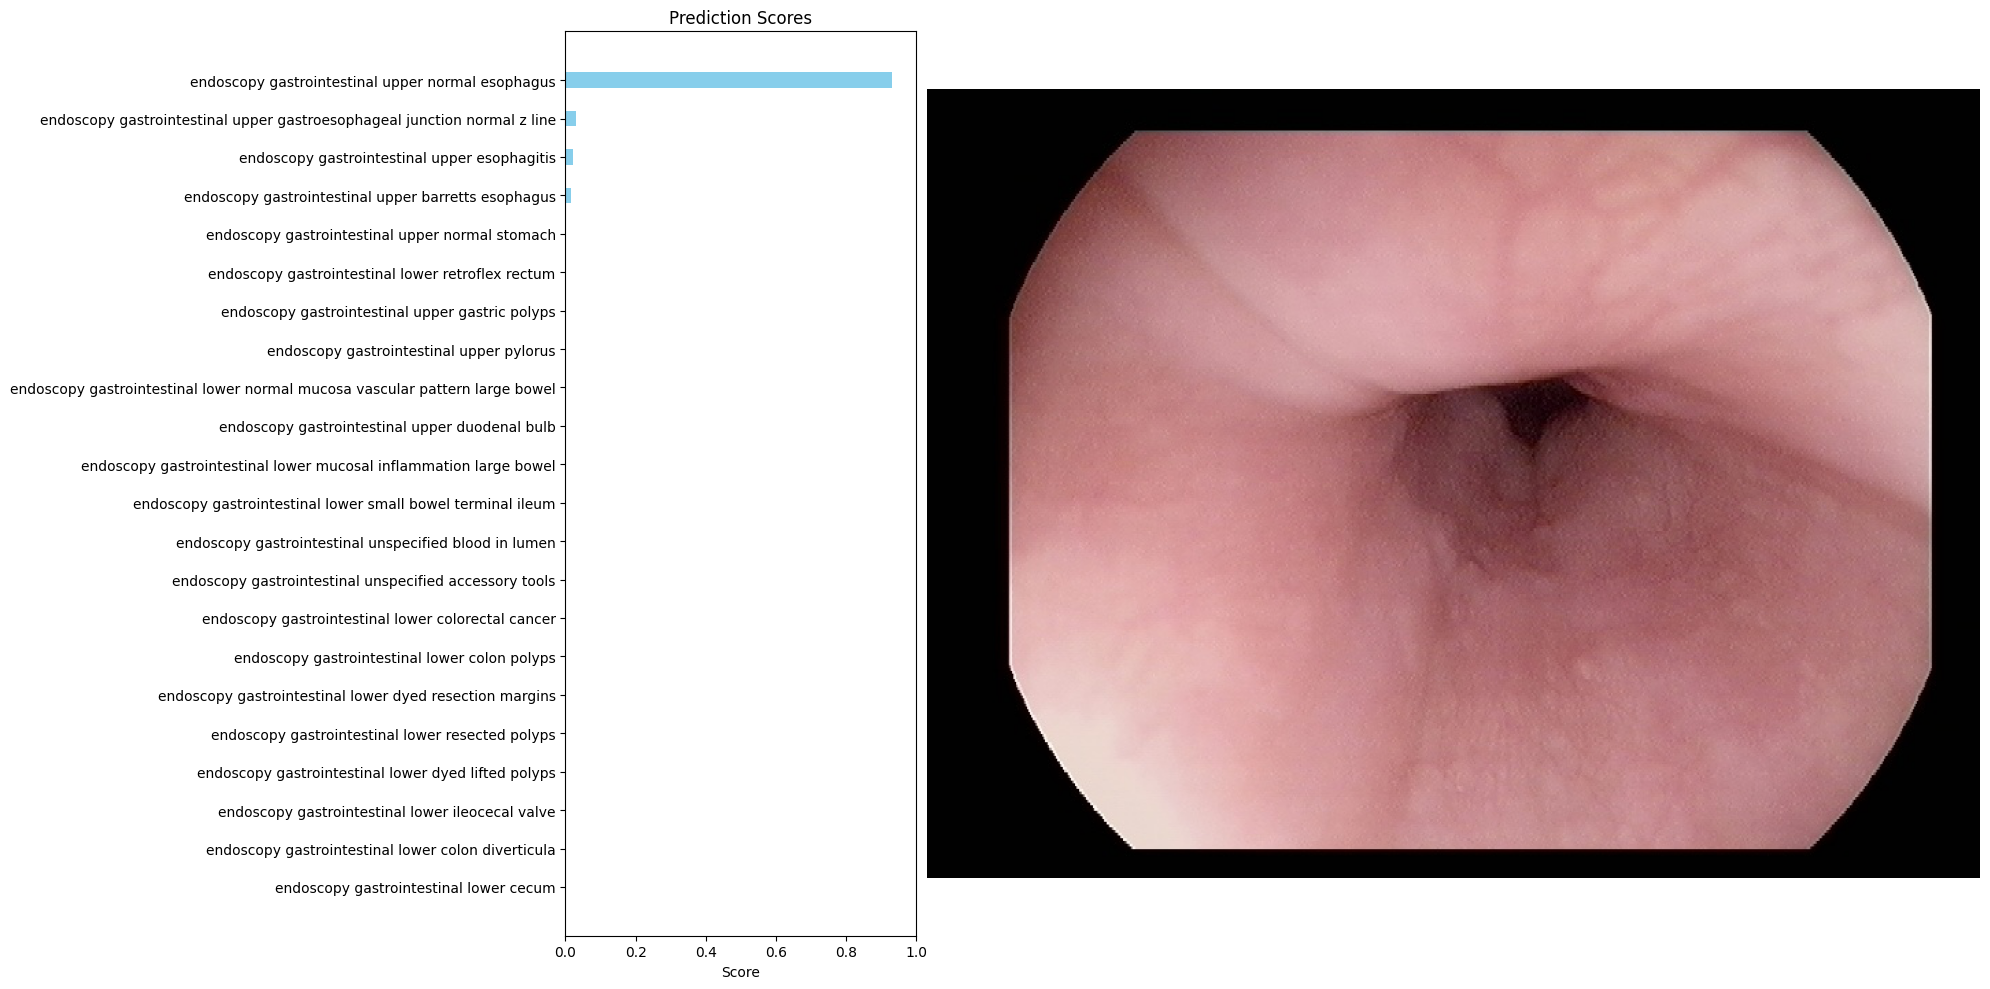

In [ ]:
import base64
from PIL import Image
import matplotlib.pyplot as plt

test_image = os.path.join(
    gastrovision_root_directory,
    "Normal esophagus/0a760aaa-d061-419b-ab2d-8311e6ca50c8.jpg",
)
with open(test_image, "rb") as f:
    image = base64.b64encode(f.read()).decode("utf-8")
    response = make_request(image)[0]

labels, scores = zip(
    *[
        (r["label"], r["score"])
        for r in sorted(response, key=lambda x: x["score"], reverse=True)
    ][::-1]
)


fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [1, 3]})
axes[1].imshow(plt.imread(test_image))
axes[1].axis("off")

axes[0].barh(labels, scores, color="skyblue", height=0.4)
axes[0].set_xlim(0, 1)
axes[0].set_xlabel("Score")
axes[0].set_title("Prediction Scores")
plt.tight_layout()

## Collect results

Now we a function to collect the actual and predicted results for the validation and test datasets. It iterates through the images, makes predictions, and stores the results in dataframes.


In [ ]:
import pandas as pd
import json
from tqdm import tqdm


def collect_results(image_df, text_df):
    """
    Collect actual and predicted results for images.
    """
    actual_predicted_results = []
    all_scores = []
    for i, row in tqdm(image_df.iterrows(), total=len(image_df), ncols=120):
        my_data = row["image"]
        result = make_request(my_data)[0]
        predicted = result[0]["label"]
        all_scores += [{"id": row["id"], **r} for r in result]
        text = text_df[text_df["id"] == row["id"]]["text"].iloc[0]
        actual = json.loads(text)["class_name"]
        actual_predicted_results.append(
            {"id": row["id"], "label": actual, "predicted": predicted}
        )

    return pd.DataFrame(actual_predicted_results), pd.DataFrame(all_scores)

In [ ]:
val_image_df = pd.read_csv(
    "validation_images.tsv", sep="\t", header=None, names=["id", "image"]
)
val_text_df = pd.read_csv(
    "validation_text.tsv", sep="\t", header=None, names=["id", "text"]
)

val_actual_predicted_results, all_val_scores = collect_results(
    val_image_df, val_text_df
)

test_image_df = pd.read_csv(
    "test_images.tsv", sep="\t", header=None, names=["id", "image"]
)
test_text_df = pd.read_csv("test_text.tsv", sep="\t", header=None, names=["id", "text"])

test_actual_predicted_results, all_test_scores = collect_results(
    test_image_df, test_text_df
)

100%|███████████████████████████████████████████████████████████████████████████████| 1586/1586 [05:27<00:00,  4.84it/s]


## Calculate best thresholds

This section defines functions to calculate the best thresholds for each class based on the validation dataset. It also converts the dataframes to matrices for easier metric evaluation.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score


def calculate_best_thresholds(prob_matrix, y_gt):
    """
    Calculate the best thresholds for each class based on the validation set.
    """
    thresholds = []
    y_pred_thresholded = []

    for i in range(prob_matrix.shape[1]):  # for each class
        y_true_class = (np.array(y_gt) == i) * 1
        y_pred_class = prob_matrix[:, i]
        best_f1 = 0
        best_thres = 0

        # on the validation set, find the threshold that achieves the best F1 score
        for thres in range(20):
            thres /= 20.0
            y_pred_class_binary = (y_pred_class >= thres) * 1
            f1 = f1_score(y_true_class, y_pred_class_binary)
            if f1 >= best_f1:
                best_thres = thres
                best_f1 = f1
        thresholds.append(best_thres)
        y_pred_thresholded.append((prob_matrix[:, i] >= best_thres) * 1)
    return thresholds, y_pred_thresholded


def df_to_matrix(df):
    """
    Convert dataframe to matrix format.
    """
    unique_ids = df["id"].unique()
    matrix = [
        [
            row["score"]
            for row in sorted(
                df[df["id"] == id].to_dict("records"),
                key=lambda x: class_dict[x["label"]],
            )
        ]
        for id in unique_ids
    ]
    return np.array(matrix)


# Extract actual and predicted labels for validation and test datasets
eval_actual_labels = val_actual_predicted_results["label"].values
eval_predicted_labels = val_actual_predicted_results["predicted"].values
actual_labels = test_actual_predicted_results["label"].values
predicted_labels = test_actual_predicted_results["predicted"].values

# Create a dictionary to map class names to indices
class_dict = {name: index for index, name in enumerate(unique_texts)}

# Convert labels to indices
eval_y_true = [class_dict[label] for label in eval_actual_labels]
eval_y_pred = [class_dict[label] for label in eval_predicted_labels]
y_true = [class_dict[label] for label in actual_labels]
y_pred = [class_dict[label] for label in predicted_labels]

# Convert validation scores to a probability matrix
val_probabilities = df_to_matrix(all_val_scores)

# Calculate the best thresholds for each class based on the validation set and convert to a probability matrix
thresholds, y_pred_thresholded = calculate_best_thresholds(
    val_probabilities, eval_y_true
)
test_probabilities = df_to_matrix(all_test_scores)

# Use the thresholds to binarize the predicted probabilities on the test set
y_pred_thresholded = [
    (test_probabilities[:, i] >= thresholds[i]) * 1
    for i in range(test_probabilities.shape[1])
]

# Create a one-hot encoded matrix for the true labels
y_pred_thresholded = np.array(y_pred_thresholded).T
y_true_onehot = np.zeros_like(y_pred_thresholded)
y_true_onehot[np.arange(y_true_onehot.shape[0]), y_true] = 1

## Metrics Calculations
Next, we compute key classification metrics using the predictions from our classifier.  We calculate macro and micro averages for precision, recall, and F1 scores, as well as the Matthews correlation coefficient (MCC) and the multi-class AUC (mAUC).  The results are then displayed in a DataFrame for easy review.

In [ ]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    matthews_corrcoef,
)
import pandas as pd

data = {
    "Metric": [
        "Precision (macro)",
        "Recall (macro)",
        "F1 Score (macro)",
        "Precision (micro)",
        "Recall (micro)",
        "F1 Score (micro)",
        "MCC",
        "mAUC",
    ],
    "Value": [
        precision_score(y_true_onehot, y_pred_thresholded, average="macro"),
        recall_score(y_true_onehot, y_pred_thresholded, average="macro"),
        f1_score(y_true_onehot, y_pred_thresholded, average="macro"),
        precision_score(y_true_onehot, y_pred_thresholded, average="micro"),
        recall_score(y_true_onehot, y_pred_thresholded, average="micro"),
        f1_score(y_true_onehot, y_pred_thresholded, average="micro"),
        matthews_corrcoef(y_true, y_pred),
        roc_auc_score(y_true, test_probabilities, average="macro", multi_class="ovr"),
    ],
}

pd.DataFrame(data).set_index("Metric").T

Metric,Precision (macro),Recall (macro),F1 Score (macro),Precision (micro),Recall (micro),F1 Score (micro),MCC,mAUC
Value,0.735756,0.771882,0.740367,0.834761,0.860025,0.847205,0.81896,0.989378


['endoscopy gastrointestinal lower colon polyps'
 'endoscopy gastrointestinal upper normal esophagus'
 'endoscopy gastrointestinal unspecified accessory tools' ...
 'endoscopy gastrointestinal lower normal mucosa vascular pattern large bowel'
 'endoscopy gastrointestinal upper normal stomach'
 'endoscopy gastrointestinal lower normal mucosa vascular pattern large bowel']


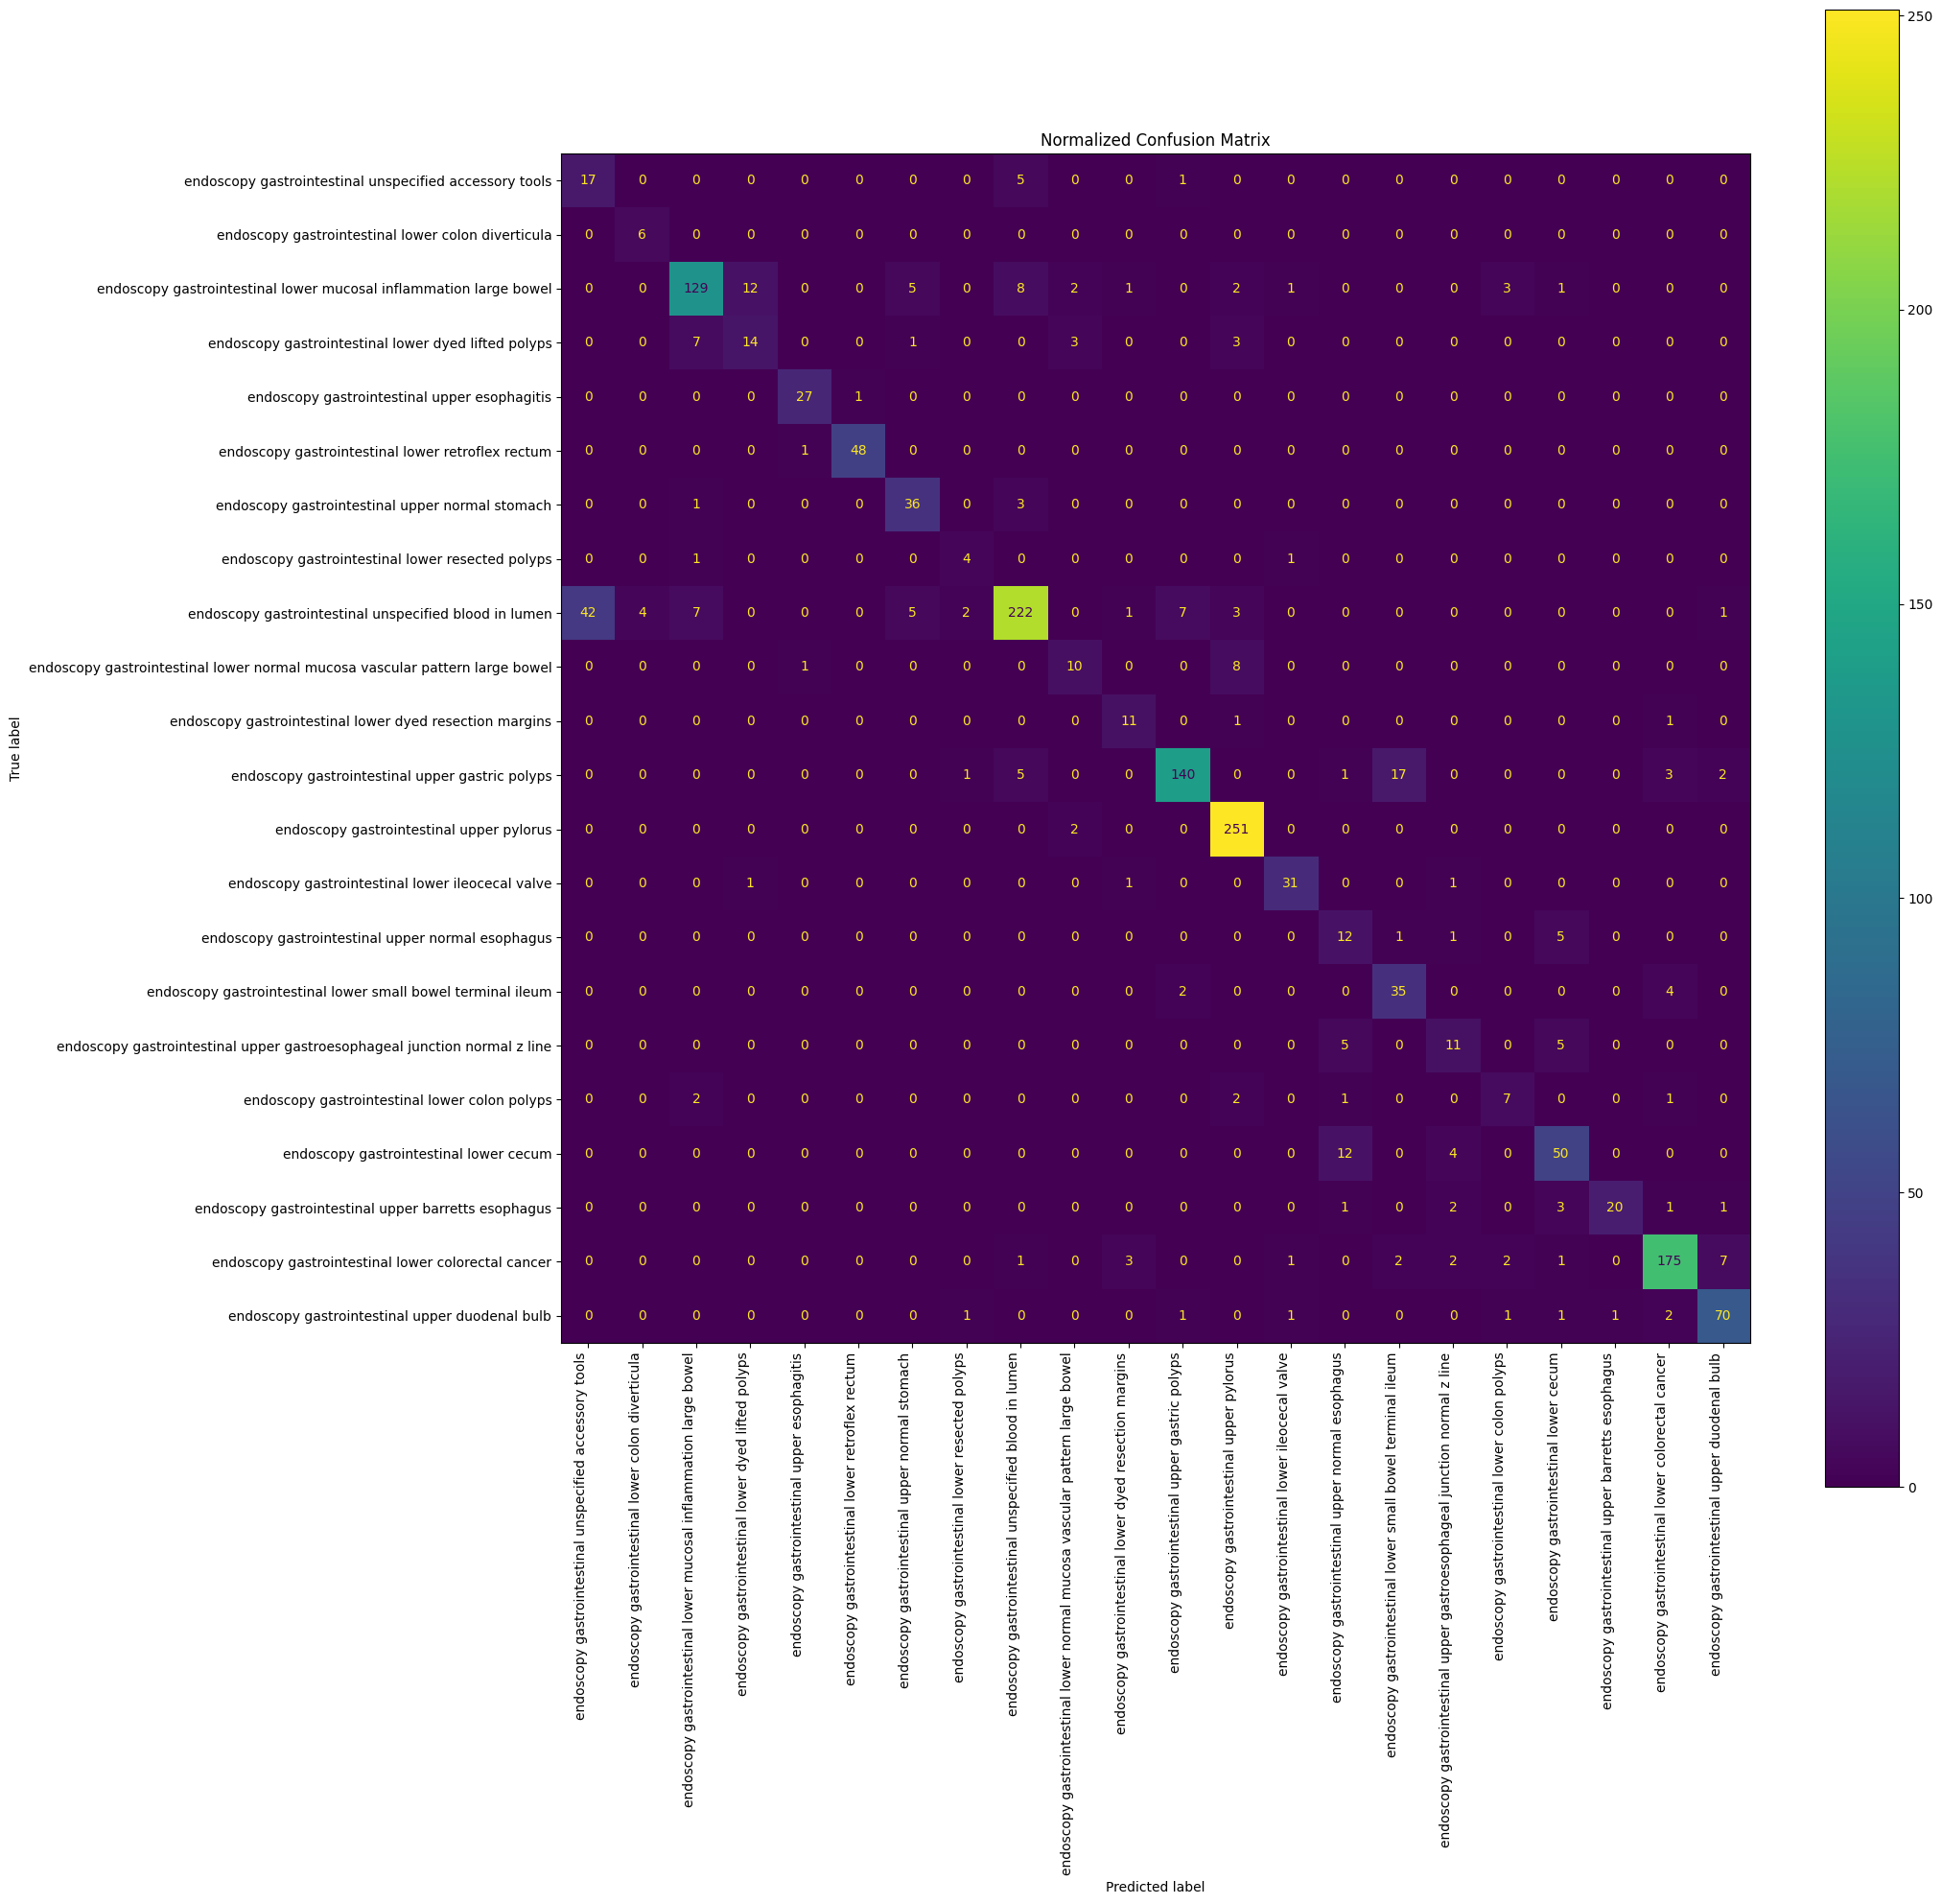

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt


print(actual_labels)
cm = confusion_matrix(actual_labels, predicted_labels, normalize=None)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=(set(actual_labels)),
)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax)
plt.xticks(rotation=90, ha="right")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0, target_names=unique_texts))

                                                                             precision    recall  f1-score   support

                           endoscopy gastrointestinal lower ileocecal valve       0.77      0.90      0.83        40
                          endoscopy gastrointestinal lower retroflex rectum       0.65      0.85      0.73        13
                         endoscopy gastrointestinal lower colon diverticula       0.60      1.00      0.75         6
                          endoscopy gastrointestinal upper normal esophagus       0.95      0.71      0.82        28
                         endoscopy gastrointestinal lower colorectal cancer       0.52      0.50      0.51        28
endoscopy gastrointestinal lower normal mucosa vascular pattern large bowel       0.91      0.76      0.83       294
                            endoscopy gastrointestinal upper gastric polyps       0.54      0.54      0.54        13
                                   endoscopy gastrointestinal u

In [ ]:
_ = ml_client.online_endpoints.begin_delete(name=endpoint.name).wait()

...........................................................................................

# Conclusion and Final Remarks

This notebook outlines an efficient workflow for fine-tuning the MedImageInsight model using AzureML pipelines. The process—from data ingestion through training and evaluation—provides a clear path to achieve reproducible results at scale.

**Key Takeaways:**
- The structured approach presented here enables easy iteration and further refinement.
- Future enhancements may include hyperparameter tuning, cross-validation, and advanced visualization of model outputs.
- Continued monitoring and retraining with updated data will help maintain model accuracy in production.
- You can easily adapt this workflow to your own data by modifying the data ingestion and preprocessing steps, ensuring that your data meets the model's input requirements.
- This workflow highlights how cloud-based platforms like AzureML simplify scaling and deployment, bridging the gap between research and clinical applications.

This approach offers a practical framework for building and deploying high-quality models in real-world scenarios.
